In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [3]:
df = pd.read_csv("~/GitHubRepos/FinancialEconometrics/DataWork/Data/General_ds_cleaned.csv")
# df = df[["date", "beta0", "beta1", "beta2", "tau", "WLbeta0", "WLbeta1", "WLbeta2", "WLtau"]]
df = df[["date", "beta0", "beta1", "beta2", "tau"]]
# df = df[["date", "0.25", "0.5", "0.75", "1.0", "2.0", "3.0", "5.0", "7.0", "10.0", "15.0", "20.0", "30.0"]]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", drop=True, inplace=True)
df

,beta0,beta1,beta2,tau
date,,,,
2003-01-04,850.031170,-299.987941,100.005078,0.000016
2003-01-05,850.031097,-299.988336,100.004988,0.000002
2003-01-08,850.032418,-299.987725,100.005295,0.000013
2003-01-09,850.035191,-299.986787,100.005729,0.000015
2003-01-10,850.030915,-299.988803,100.004964,0.000012
...,...,...,...,...
2023-11-27,1178.762726,392.865962,-572.515166,0.344359
2023-11-28,1176.287596,349.812713,-497.037336,0.348622
2023-11-29,1176.081378,456.633996,-658.044054,0.306983


Посмотрим на данные. Возможно лучшими моделями будут модели смешанной частоты.

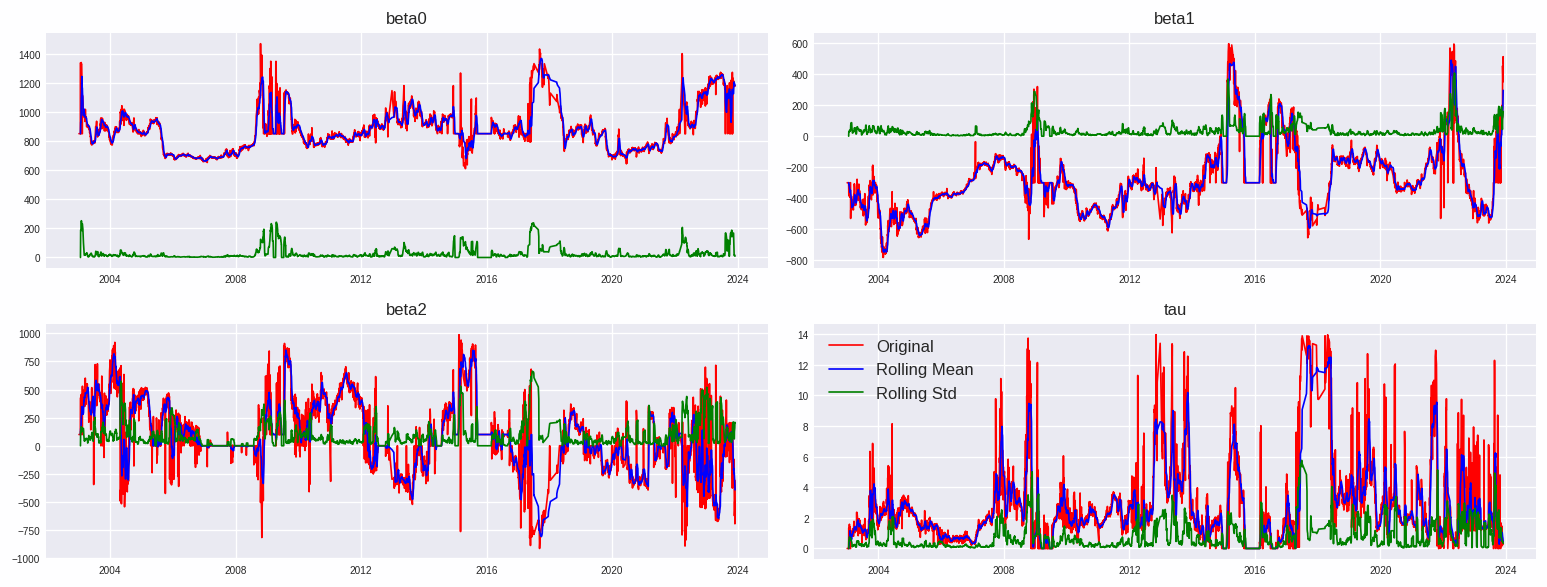

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(13,5))
for i, ax in enumerate(axes.flat):
    data = df[df.columns[i]]
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()
    ax.plot(data, color='red', linewidth=1, label='Original')
    ax.plot(rolling_mean, color='blue', linewidth=1, label='Rolling Mean')
    ax.plot(rolling_std, color='green', linewidth=1, label='Rolling Std')
    ax.set_title(df.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.legend(loc='best')
plt.tight_layout();

Посмотрим тест Granger's на причинность.

In [8]:
maxlag=10

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

matrix_granger = grangers_causation_matrix(df, variables = df.columns)

Получим таблицу с p-value причинности.

In [9]:
matrix_granger[matrix_granger < 0.05]

,beta0_x,beta1_x,beta2_x,tau_x
beta0_y,NaN,0.0351,0.0011,0.0005
beta1_y,0.0280,NaN,0.0018,0.0042
beta2_y,0.0119,0.0001,NaN,0.0000
tau_y,0.0112,NaN,0.0000,NaN


Теперь проверим на коинтеграцию, тк это является основной предпосылкой для VAR. 

In [10]:
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df, -1, 5)
    d = {'0.90' : 0, '0.95' : 1, '0.99' : 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
beta0  ::  152.67    > 40.1749   =>   True
beta1  ::  58.79     > 24.2761   =>   True
beta2  ::  18.0      > 12.3212   =>   True
tau    ::  0.35      > 4.1296    =>   False


Теперь приступим к разбивке на test и train(с помощью дат полученных из структурных сдвигов). Для train вычитают 5 дней от структурного сдвига, а промежуток в 5 дней беру на test.
### МЕНЯТЬ ТОЛЬКО ЗДЕСЬ!!!
1. n_horizon — количество дней, на которое предсказываем 
1. epoch — промежуток, который исследуем

In [11]:
n_horizon = 5
dates_from_struct_ms = np.array([0, 657, 1384, 3943, 4502])


time_to_fit = np.maximum((dates_from_struct_ms - n_horizon), np.zeros(len(dates_from_struct_ms))).astype(int)
time_to_predict = dates_from_struct_ms

epoch = 3
df_train, df_test = df[time_to_fit[epoch]:time_to_fit[epoch + 1]], df[time_to_fit[epoch + 1]:time_to_predict[epoch + 1]]
df_train

,beta0,beta1,beta2,tau
date,,,,
2019-10-10,871.472878,-238.861462,-252.555101,5.546608
2019-10-11,871.401875,-236.827888,-250.549455,5.949593
2019-10-14,880.116830,-248.834162,-246.235740,6.604045
2019-10-15,826.110447,-193.436764,-212.103603,5.188040
2019-10-16,829.433273,-200.437511,-181.145054,6.040058
...,...,...,...,...
2022-02-07,850.666836,118.516641,57.097672,9.022855
2022-02-08,877.445271,95.516239,-0.013026,9.773161
2022-02-09,890.734984,85.758156,-0.000021,6.883329


Проверим на стационарность.

In [12]:
def adjust(val, length= 6): return str(val).ljust(length)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [13]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "beta0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4843
 No. Lags Chosen       = 0
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.1193. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "beta1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8242
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.992. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "beta2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

Получили, что не все стационарны. Возьмем разницу и снова проверим.

In [14]:
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "beta0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.1577
 No. Lags Chosen       = 0
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7822
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [15]:
max_parametrs_for_var = 10
model = VAR(df_differenced)
for i in np.arange(1,max_parametrs_for_var):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  20.451392474181663
BIC :  20.606601279924114
FPE :  761952216.1272483
HQIC:  20.51201186507576 

Lag Order = 2
AIC :  20.393605482284002
BIC :  20.67336745817073
FPE :  719176089.2863033
HQIC:  20.502879826123515 

Lag Order = 3
AIC :  20.363027696434163
BIC :  20.76768777195635
FPE :  697534113.1269873
HQIC:  20.521099436714223 

Lag Order = 4
AIC :  20.373367205034945
BIC :  20.903271895827032
FPE :  704813862.4361658
HQIC:  20.580379453319228 

Lag Order = 5
AIC :  20.416688584071085
BIC :  21.072186002023845
FPE :  736069236.5206834
HQIC:  20.672785124280594 

Lag Order = 6
AIC :  20.4549308367141
BIC :  21.236370700170095
FPE :  764841260.7727082
HQIC:  20.760256129450877 

Lag Order = 7
AIC :  20.481475167002248
BIC :  21.38920881103444
FPE :  785526379.4139409
HQIC:  20.836174353908323 

Lag Order = 8
AIC :  20.49174187543633
BIC :  21.52612226221069
FPE :  793781762.2507391
HQIC:  20.89596078358828 

Lag Order = 9
AIC :  20.530764765523955
BIC :  21.6921464

Получили, что лучший параметр $p = 9$.

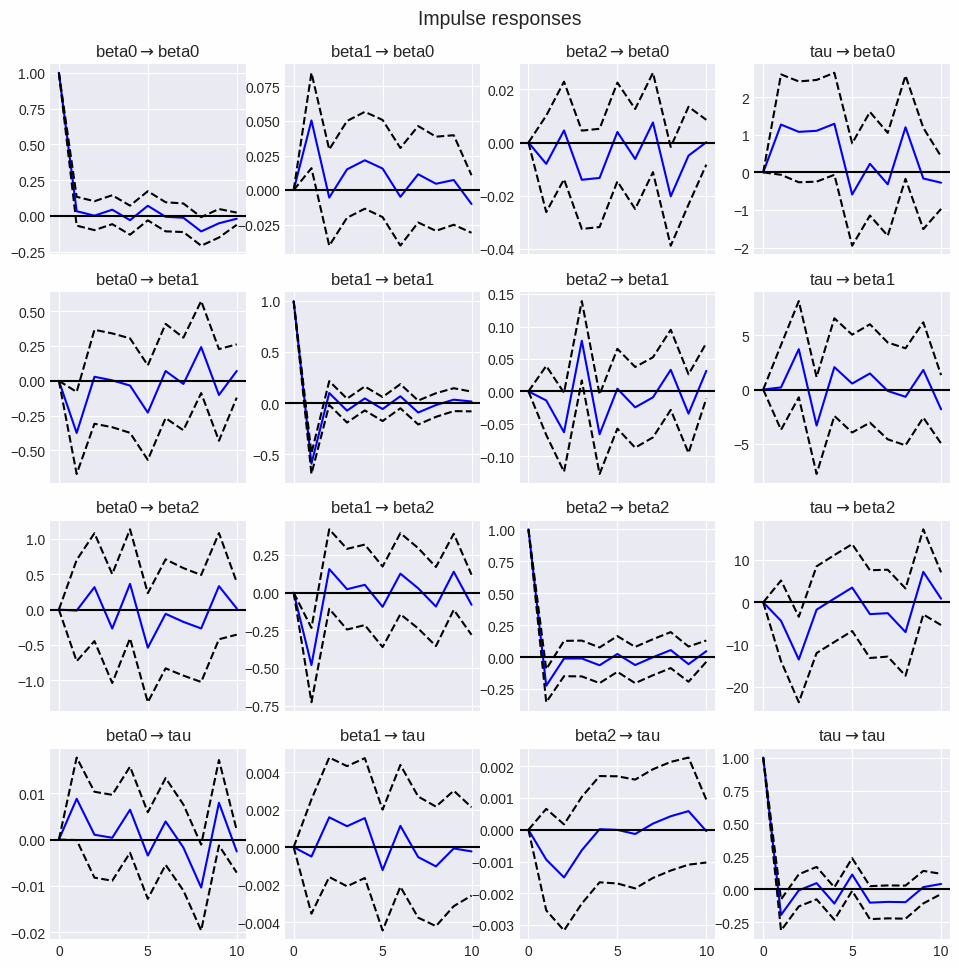

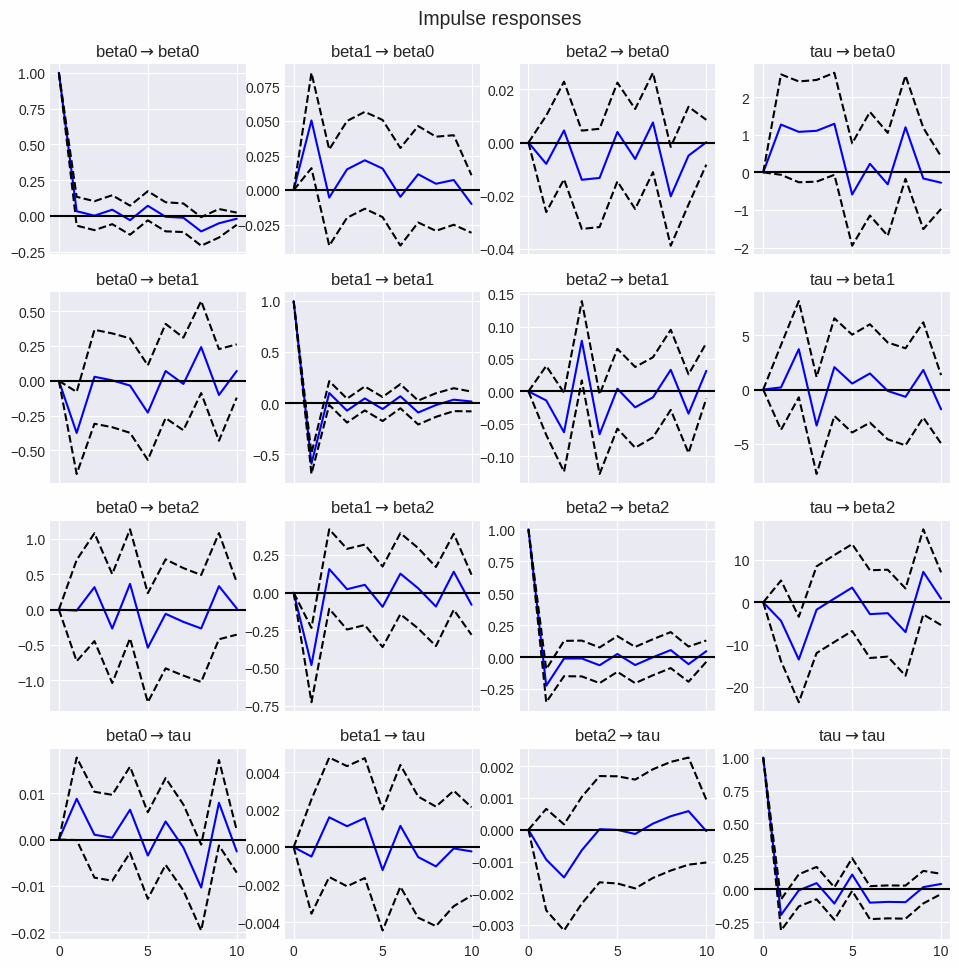

In [16]:
p = 9
model_fitted = model.fit(p)
model_fitted.summary()
model_fitted.irf(periods=10, var_decomp=None, var_order=None).plot()

Изучим статистику Durbina для проверки корреляций между остатками. Иначе если в остатках есть корреляция, то во временном ряду есть закономерность, которую нужну объяснить.

In [17]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

beta0  : 2.0
beta1  : 2.0
beta2  : 2.0
tau    : 1.99


Остатки выглядят очень хорошо(очень близко к 2). Теперь осталось рассмотреть предсказания. Учтем также то, что лучше всего брать промежуток для форкаста равный количестве лагов. В нашем же случае все совпало и мы точно разделили выборку.

In [18]:
var_model_forecast = model_fitted.forecast(y = df_differenced.values, steps=n_horizon)
df_forecast = pd.DataFrame(var_model_forecast, index = df_test.index, columns = df.columns + '_1d' )
df_forecast

,beta0_1d,beta1_1d,beta2_1d,tau_1d
date,,,,
2022-02-14,-9.095459,-0.699567,35.529054,0.353333
2022-02-15,-5.048304,-30.301842,13.103342,-0.153085
2022-02-16,3.525548,10.896832,-25.381952,-0.660876
2022-02-17,-6.097795,-6.132097,12.853154,0.545738
2022-02-18,2.257247,-10.467778,-22.004829,-0.176278


In [19]:
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [20]:
df_results = invert_transformation(df_train, df_forecast)
df_results

,beta0_1d,beta1_1d,beta2_1d,tau_1d,beta0_forecast,beta1_forecast,beta2_forecast,tau_forecast
date,,,,,,,,
2022-02-14,-9.095459,-0.699567,35.529054,0.353333,907.558731,95.228785,140.868760,3.611395
2022-02-15,-5.048304,-30.301842,13.103342,-0.153085,902.510427,64.926943,153.972102,3.458310
2022-02-16,3.525548,10.896832,-25.381952,-0.660876,906.035975,75.823776,128.590150,2.797434
2022-02-17,-6.097795,-6.132097,12.853154,0.545738,899.938180,69.691678,141.443304,3.343172
2022-02-18,2.257247,-10.467778,-22.004829,-0.176278,902.195426,59.223900,119.438475,3.166894


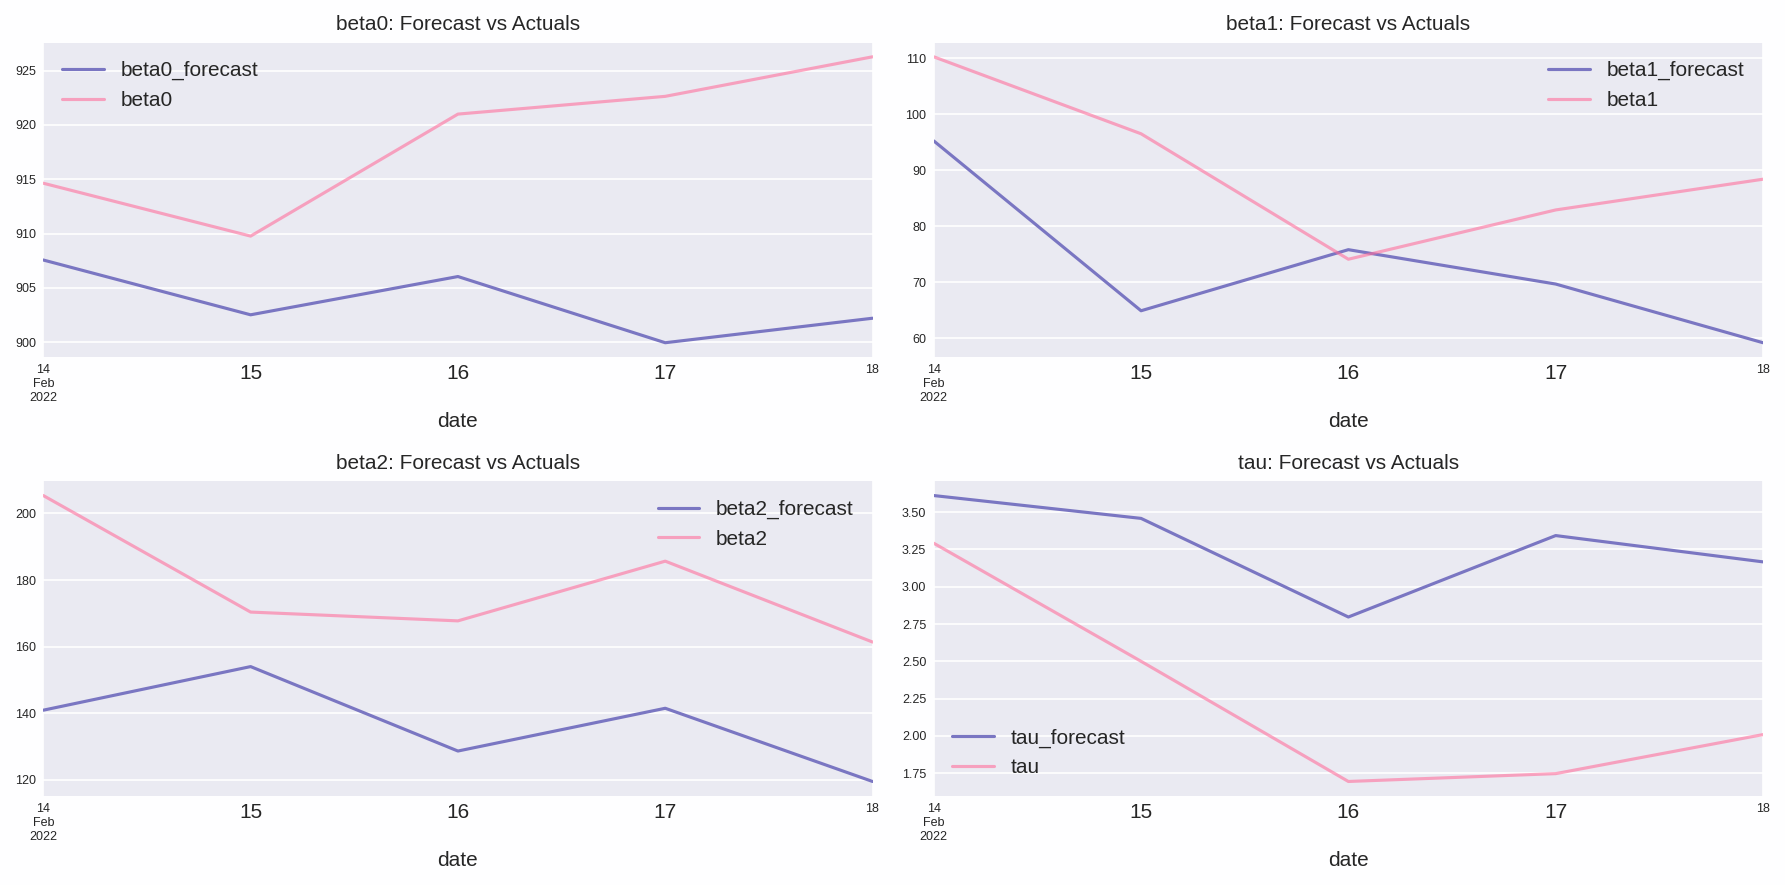

In [22]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(12, 6))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals", fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [23]:
df_results

,beta0_1d,beta1_1d,beta2_1d,tau_1d,beta0_forecast,beta1_forecast,beta2_forecast,tau_forecast
date,,,,,,,,
2022-02-14,-9.095459,-0.699567,35.529054,0.353333,907.558731,95.228785,140.868760,3.611395
2022-02-15,-5.048304,-30.301842,13.103342,-0.153085,902.510427,64.926943,153.972102,3.458310
2022-02-16,3.525548,10.896832,-25.381952,-0.660876,906.035975,75.823776,128.590150,2.797434
2022-02-17,-6.097795,-6.132097,12.853154,0.545738,899.938180,69.691678,141.443304,3.343172
2022-02-18,2.257247,-10.467778,-22.004829,-0.176278,902.195426,59.223900,119.438475,3.166894


In [24]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)    
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [25]:
for col_name in df.columns:
    print('Forecast Accuracy of: ' + col_name)
    accuracy_prod = forecast_accuracy(df_results[col_name + '_forecast'].values, df_test[col_name])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: beta0
mape   :  0.0165
me     :  -15.2129
mae    :  15.2129
mpe    :  -0.0165
rmse   :  16.8615
Forecast Accuracy of: beta1
mape   :  0.1951
me     :  -17.4511
mae    :  18.1336
mpe    :  -0.1859
rmse   :  21.2148
Forecast Accuracy of: beta2
mape   :  0.2283
me     :  -41.2338
mae    :  41.2338
mpe    :  -0.2283
rmse   :  43.9873
Forecast Accuracy of: tau
mape   :  0.5238
me     :  1.0265
mae    :  1.0265
mpe    :  0.5238
rmse   :  1.1063
